In [1]:
import numpy as np
from scipy.stats import norm, expon
from scipy.integrate import quad, quad_vec
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
%load_ext rpy2.ipython

C:\Users\tiger\AppData\Local\Programs\Python\Python37\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


# Exercise 1

## (a)

In [3]:
def fhat(X, x0, h):
    return (h*X.shape[0])**(-1) * norm.pdf((x0-X)/h).sum()

def g0(s, t):
    return norm.cdf(t) - norm.cdf(s)

def g1(s, t):
    return -norm.pdf(t) + norm.pdf(s)

def g2(s, t):
    return -t*norm.pdf(t) + s*norm.pdf(s) + norm.cdf(t) - norm.cdf(s)

def fL_hat(X, x0, h, a, b):
    lower, upper = (x0-b)/h, (x0-a)/h
    mu = (x0-X)/h
    return (h*X.shape[0])**(-1) * ((g2(lower, upper)*norm.pdf(mu) - (g1(lower, upper)*mu*norm.pdf(mu))) / \
                                    (g0(lower, upper)*g2(lower, upper) - (g1(lower, upper))**2)).sum()

## 畫圖

In [4]:
%R set.seed(1)
%R xa_r <- runif(5000)

# np.random.seed(1)
# xa = np.random.rand(5000)

xa = %R xa_r
ya1 = []
for i in np.linspace(0, 1, 5000):
    ya1.append(fhat(X=xa, x0=i, h=0.07))

ya2 = []
for i in np.linspace(0, 1, 5000):
    ya2.append(fL_hat(X=xa, x0=i, h=0.07, a=0, b=1))

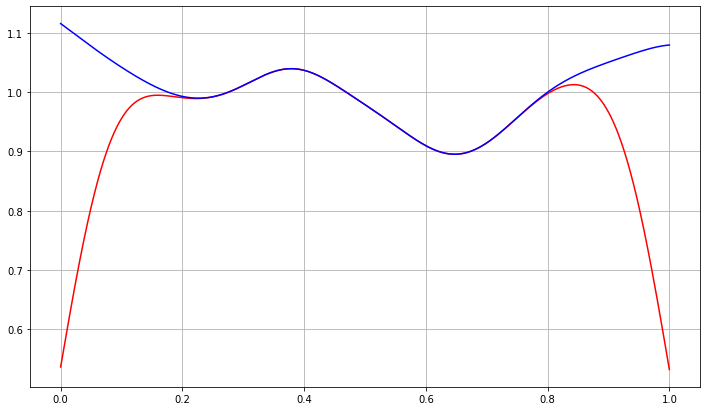

In [5]:
plt.figure(figsize=(12, 7))
plt.grid()
plt.plot(np.linspace(0,1,5000), ya1, c="r")
plt.plot(np.linspace(0,1,5000), ya2, c="b")
plt.show()

## (b)

In [6]:
n = 5000

In [7]:
SE_list_fixed = []
for i in range(200):
    np.random.seed(i)
    SE_list_fixed.append((fL_hat(np.random.rand(n), x0=np.random.rand(1), h=0.08, a=0, b=1) - 1)**2)

In [8]:
print("IMSE with fixed: ", np.array(SE_list_fixed).mean())

IMSE with fixed:  0.0008398360524927354


## (c)

In [9]:
SE_list = []
for i in range(200):
    np.random.seed(i)
    SE_list.append((fhat(np.random.rand(n), x0=np.random.rand(1), h=0.08) - 1)**2)

In [10]:
print("IMSE: ", np.array(SE_list).mean())

IMSE:  0.019820789839317142


# Exercise 2

## (a)

In [11]:
n2 = 100
x2 = np.random.randn(n2)
h = [i/100 for i in range(1, 51, 2)]

In [12]:
def LSCV(h):
    def integrate_f(w):
        return (fhat(X=x2, x0=w, h=h))**2
    fhat_list = []
    for j in range(100):
        x_loo = np.delete(x2, j)
        fhat_list.append(fhat(X=x_loo, x0=np.random.rand(1), h=h))
    return quad(integrate_f, 0, 1)[0] - (2/n2)*sum(fhat_list)

In [13]:
# LSCV_with_different_h = []
# for index, h_tmp in enumerate(h, 1):
#     np.random.seed(index)
#     LSCV_with_different_h.append(LSCV(h=h_tmp))

In [14]:
# dict(zip([i/100 for i in range(1,51,2)], LSCV_with_different_h))

### 使用最佳化來查找h

In [15]:
minimize(LSCV, x0=0.3, method='Nelder-Mead')

 final_simplex: (array([[0.3065625],
       [0.3065625]]), array([-0.55089915, -0.55088723]))
           fun: -0.5508991516116716
       message: 'Optimization terminated successfully.'
          nfev: 75
           nit: 28
        status: 0
       success: True
             x: array([0.3065625])

In [16]:
LSCV(h=0.07)

-0.5226037413813682

In [17]:
def fhat2a(w):
    X = x2
    h = 0.07
    return (((h*X.shape[0])**(-1) * norm.pdf((w-X)/h).sum() - norm.pdf(w))**2)

In [18]:
quad(fhat2a, 0, 1)

(0.01514593172995871, 1.3306686928417832e-10)

In [19]:
h_lista = []
ise_list2a = []
for i in range(200):
    np.random.seed(i)
    x2 = np.random.randn(n2)
    h2a = minimize(LSCV, x0=0.3, method='Nelder-Mead').x
    h_lista.append(h2a)
    ise_list2a.append(quad(fhat2a, 0, 1)[0])

In [20]:
print("Max: ", max(h_lista), "Min: ", min(h_lista), "Mean: ", np.array(h_lista).mean())

Max:  [0.46500732] Min:  [0.1424707] Mean:  0.30638132556695447


In [21]:
print("Max: ", max(ise_list2a), "Min: ", min(ise_list2a), "Mean: ", np.array(ise_list2a).mean())

Max:  0.060872590878854965 Min:  0.0015758973670190791 Mean:  0.012346728131395417


In [22]:
print(np.array(ise_list2a).mean())

0.012346728131395417


## (b)

In [23]:
def neg_LikCV(h):
    fhat_list = []
    for j in range(100):
        x_loo = np.delete(x2, j)
        fhat_list.append(fhat(X=x_loo, x0=np.random.rand(1), h=h))
    return -1 * np.sum(np.log(np.array(fhat_list)))

In [24]:
h2b = minimize(neg_LikCV, x0=0.3, method='Nelder-Mead').x
print(h2b)

[0.3]


In [25]:
def fhat2b(w):
    X = x2
    return (((h2b*X.shape[0])**(-1) * norm.pdf((w-X)/h2b).sum() - norm.pdf(w))**2)

In [26]:
quad(fhat2b, 0, 1)

(0.0011206183637333146, 5.996227137113946e-13)

In [27]:
h_listb = []
ise_list2b = []
for i in range(200):
    np.random.seed(i)
    x2 = np.random.randn(n2)
    h2b = minimize(neg_LikCV, x0=0.3, method='Nelder-Mead').x
    h_listb.append(h2b)
    ise_list2b.append(quad(fhat2b, 0, 1)[0])

C:\Users\tiger\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [28]:
print("Max: ", max(ise_list2b), "Min: ", min(ise_list2b), "Mean: ", np.array(ise_list2b).mean())

Max:  0.01345560567808948 Min:  2.4354408942165068e-05 Mean:  0.0021954463385550236


In [29]:
print(max(h_listb), min(h_listb))

[0.46500732] [0.08894531]


# Exercise 3

## (a)

In [30]:
x3 = np.random.exponential(size=5000)
h3 = 0.08

In [31]:
fhat3a = []
for i in range(200):
    fhat3a.append(fhat(np.random.exponential(size=5000), 0, h3))
fhat3a = np.array(fhat3a)

In [32]:
fhat3a.mean() - expon.pdf(0)

-0.5323099361903217

## (b)

In [33]:
def g2_pro(X, h, s, t):
    ifunc = lambda v: ((v-X)/h)**2 * norm.pdf((v-X)/h)
    return quad_vec(ifunc, s, t)[0]
s, t = (0-np.inf)/h3, (0-0)/h3

In [34]:
g2_pro(x3, h3, s, t)

array([ 2.51917054e-19,  1.28483911e-66,  3.97026515e-02, ...,
        6.97728728e-14, -0.00000000e+00,  3.18899381e-15])

In [37]:
def g2_alter(s, t):
    return -t*norm.pdf(t) + norm.cdf(t) - norm.cdf(s) + 0 # s*norm.pdf(s)

def fL_hat3b(X, x0, h, a, b):
    s, t = (x0-b)/h, (x0-a)/h
    mu = (x0-X)/h
    # print(g0(s, t), g1(s,t), g2_alter(X=x3, h=h, s=s, t=t).shape, mu.shape, norm.pdf(mu).shape)
    return (h*X.shape[0])**(-1) * ((g2_alter(s=s, t=t)*norm.pdf(mu) - (g1(s, t)*mu*norm.pdf(mu))) / \
                                    (g0(s, t)*g2_alter(s=s, t=t) - (g1(s, t))**2)).sum()

In [38]:
fL_hat3b(x3, 0, h3, a=0, b=np.inf)

0.9537745380834254

In [39]:
def ise3b(w):
    return (fL_hat3b(x3, w, h3, a=0, b=np.inf) - expon.pdf(w))**2

In [40]:
quad(ise3b, 0, np.inf)

(0.00026037376734303763, 1.1552850714181675e-08)